# Annotation of Tweets
In order to train a machine learning model we gathered ground truth data from a crowdsourcing task. Alternative to traditional gold standard data collection methods which employ expert annotaters and rely on single right answer for truth, we use an open-sourced crowdsourcing approach which relies on subjectivity the in human interpretations for gathering multiple annotations. The [CrowdTruth Framework](https://github.com/CrowdTruth/CrowdTruth) harnesses disagreement to yield higher quality results, rather than eliminating it.

Due to subjectivity in human interpretations of semantic data, disagreement between annotators is naturally produced as more people labeling natural language data. This is especially true in data that is inherently social, on microblogging sites such as Twitter. It is often not obvious in Tweets, which parts of speech are objects or subjects, and who is the intended audience. The inclusion of sarcasm, slang and hidden sentiment all produce extra ambiguity.

We gather multiple annotations per document, which accounts for and reflects human subjectivity in the interpretations of each document. We then measure inter-annotator disagreement between each document and each annotaion, using the cosine-similarity measure within a vector space.

Specifically we are interested in gathering data on wether or not a tweet contains news about an event. This result is correlated with certain quality characteristics, also annotated for each tweet.

#### Quality Characteristics

- Advertisement
- Personal Opinion
- Direct Quote
- Sarcasm
- Explicit Language or Graphic Content
- Not in English
- Display Error
- None

#### News Update

- NOT CONTAINS: The Tweet does not contain any news about the Event
- POSSIBLY CONTAINS: The Tweet possibly contains news about the Event
- CONTAINS: The Tweet contains news about the Event

## Steps
1. Transform Raw Data
    - count total annotations per tweet
    - unstack html radio/checkbox values
2. Apply CrowdTruth Framework
    - get annotation vectors (worker-document vectors)
    - get unit vectors
    - get aggregate document vectors
    - **worker-document disagreement**
        - calculated as the average of all cosine distances between each worker's document vector and the aggregate document vector (minus that worker) [1]
        - sudo code:
            ``` python
            for each worker:
                get worked documents
                compute document vectors minus worker
                for every other worker:
                    get worker document score as cosine distance(worker vector, document vector minus worker)
            get worker score as avg(worker document scores)
            ```
    - **worker-worker disagreement**
        - calculated as $1 - avg(k)$ where k is the pairwise metric, between every worker vector and all other worker vectors [1]
        - sudo code: 
            ``` python
            for each worker:
                for every other worker:
                    get documents overlap
                    for document in documents overlap:
                        for annotation in annotations vector:
                            get agreement
                    get worker worker document score as sum (agreement) / total annotations
            get worker score as 1 - avg(worker worker document scores)
            ```
    - **document-annotation scores** (vector)
        - calculated as the cosine distance between the each aggregate document vector and the unit vector for every annotation [1]
    - **document clarity**
        - calculated as the max annotation score for each document [1]
3. Aggregate
    - remove spam workers
        - if outlier in both worker-worker disagrmeent and worker-document disagreement
    - take those annotaions with >= .85 clarity
        - Following the CrowdTruth results demonstrated in [1], we select a threshold for document clarity that yeilds highest agreement between crowd and experts. They showed that the higher this score, the easier it is for a machine as well as human to classify.
4. Summarize
    - identify correlations between news annotations with certain quality characteristic
    - identify relationships between annotations and clarity
    

## CrowdTruth Framework:
The framework's metrics exploit ambiguity in annotations for collecting higher quality annotations. The example below considers two documents (Tweets), each being annotated by three workers. 

**annotation vectors**
- the annotation of one worker for one document

| doc | worker | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|---|
| 101 | 001 | 0 | 0 | 1 |
| 101 | 002 | 0 | 1 | 0 |
| 101 | 003 | 0 | 0 | 1 |
| 102 | 001 | 1 | 0 | 0 |
| 102 | 002 | 1 | 0 | 0 |
| 102 | 003 | 0 | 1 | 0 |
| 103 | 001 | 1 | 0 | 0 |
| 103 | 002 | 0 | 1 | 0 |
| 103 | 003 | 0 | 1 | 0 |

**document vectors**
- for every sentence, the sum of all annotation vectors

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0 | 1 | 2 |
| 102 | 2 | 1 | 0 |
| 103 | 1 | 2 | 0 |

**unit vectors**
- for every sentence, the sum of all annotation vectors

| annotation | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| NOT CONTAINS | 1 | 0 | 0 |
| POSSIBLY CONTAINS | 0 | 1 | 0 |
| CONTAINS | 0 | 0 | 1 |

**worker-document scores**

| worker | doc | worker_document_score |
|---|---|---|
| 001 | 101 | 0.71 |
| 001 | 102 | 0.71 |
| 001 | 103 | 0.00 |
| 002 | 101 | 0.00 |
| 002 | 102 | 0.71 |
| 002 | 103 | 0.71 |
| 003 | 101 | 0.71 |
| 003 | 102 | 0.00 |
| 003 | 103 | 0.71 |

| worker | avg_worker_document_score |
|---|---|
| 001 | 0.47 |
| 002 | 0.47 |
| 003 | 0.47 |

**worker-worker scores**

$k = agreement / annotations$

| worker1 | worker2 | doc | k |
|---|---|---|---|
| 001 | 002 | 101 | 0.00 |
| 001 | 002 | 102 | 0.33 |
| 001 | 002 | 103 | 0.00 |
| 001 | 003 | 101 | 0.33 |
| 001 | 003 | 102 | 0.00 |
| 001 | 003 | 103 | 0.00 |
| 002 | 001 | 101 | 0.00 |
| 002 | 001 | 102 | 0.33 |
| 002 | 001 | 103 | 0.00 |
| 002 | 003 | 101 | 0.00 |
| 002 | 003 | 102 | 0.00 |
| 002 | 003 | 103 | 0.33 |
| 003 | 001 | 101 | 0.33 |
| 003 | 001 | 102 | 0.00 |
| 003 | 001 | 103 | 0.00 |
| 003 | 002 | 101 | 0.00 |
| 003 | 002 | 102 | 0.00 |
| 003 | 002 | 103 | 0.33 |

$disagreement = (1 - avg(k))$

| worker | worker_worker_disagreement |
|---|---|
| 001 | 0.81 |
| 002 | 0.81 |
| 003 | 0.81 |

**document-annotation scores**
- the cosine similarity between the document vector and the unit vector for that annotation
    - Cosine Similarity measures the cosine distance from 0 to 1 between two equal length vectors, and is calculated as $cos(\pmb dv, \pmb uv) = \frac {\pmb dv \cdot \pmb uv}{||\pmb dv|| \cdot ||\pmb uv||}$

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0.00 | 0.45 | 0.89 |
| 102 | 0.89 | 0.45 | 0.00 |
| 103 | 0.45 | 0.89 | 0.00 |

**document clarity**
- the scores are a measure of clarity, where a higher score represents a more clear interpretation of that annotation for that document
- lower scores depict higher disagreement within the crowd, and suggest difficulty for training a machine

| doc | NOT CONTAINS | POSSIBLY CONTAINS | CONTAINS |
|---|---|---|---|
| 101 | 0.00 | 0.00 | 0.89 |
| 102 | 0.89 | 0.00 | 0.00 |
| 103 | 0.00 | 0.89 | 0.00 |

### Citations
[1] [Anca Dumitrache, Lora Aroyo, Chris Welty: Achieving Expert-Level Annotation Quality with CrowdTruth: The Case of Medical Relation Extraction. BDM2I at ISWC 2015.](http://www.ancad.ro/2015/08/14/achieving-expert-level-annotation-quality-with-crowdtruth/)

[2] [Aroyo, Chris Welty: The Three Sides of CrowdTruth. J. Human Computation. 1(1). 2014.](http://hcjournal.org/ojs/index.php?journal=jhc&page=article&op=view&path%5B%5D=34&path%5B%5D=8Lora)


#### import tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.metrics.pairwise import cosine_similarity

#### import annotation data

In [2]:
#MANUAL TEST
#cf = pd.read_csv('data/final/cf_report_FINAL_manual.csv', sep=',', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
#MANUAL TEST
#cf = pd.read_csv('data/final/cf_report_crowdtest100.csv', sep=',', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'})
cf = pd.read_csv('data/final/f933736.csv', sep=',', encoding='utf-8', header=0, parse_dates=['created_at'], dtype={'twitter_id' : 'str'}, low_memory=False)

In [3]:
cf.rename(columns={'_unit_id' : 'document_id', '_id' : 'annotation_id', '_worker_id' : 'worker_id'}, inplace=True)
#cf.drop_duplicates(subset=[['document_id', 'worker_id']], inplace=True, keep='last')
cf.sort_values(by=['event', 'twitter_id', 'text'], inplace=True)

In [4]:
cf.head(1)

,document_id,_created_at,annotation_id,_started_at,_tainted,_channel,_trust,worker_id,_country,_region,...,event4_gold,event5_gold,event6_gold,event7_gold,event8_gold,event9_gold,news_gold,news_location_gold,text,twitter_id
5650,1000144059,7/23/2016 21:23:21,2062871124,7/23/2016 21:23:06,False,neodev,0.972,24696098,GBR,G6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Race day #RedBull #LeMans24 #Porsche https://t...,744065054232973312


# 1. Transform

In [5]:
print('crowdsourced:')
print('%s unique annotations' % cf['annotation_id'].nunique())
print('%s unique tweets annotated' % cf['twitter_id'].nunique())

crowdsourced:
8860 unique annotations
886 unique tweets annotated


#### count total annotations per tweet

In [6]:
cf.groupby('document_id')['worker_id'].count().value_counts()

10    886
Name: worker_id, dtype: int64

In [7]:
#cf_annpertweet = pd.DataFrame(cf.groupby('document_id')['worker_id'].count())
#cf_annpertweet.columns = ['doc_annotations']
#cf_annpertweet.reset_index(inplace=True)
#cf = pd.merge(cf, cf_annpertweet, how='left', on=['document_id'])

In [ ]:
#cf['doc_annotations'].value_counts()

#### unstack html radio/checkbox values
- decode "news" to annotation values

In [8]:
annotation_codes = {0.0 : 'NOT CONTAINS',
                    0.5 : 'POSSIBLY CONTAINS',
                    1.0 : 'CONTAINS'}

annotations  = list(annotation_codes.values())

In [9]:
cf['news'].replace(annotation_codes, inplace=True)

for ann in annotations:
    cf[ann] = cf['news'].apply(lambda a: [0,1][a == ann])

# 2. Apply CrowdTruth Framework
### annotation vectors
- using [event, event_id] as unique doc id's
- because integrity of twitter_id was lost (CrowdFlower could not handle)

In [10]:
cols = ['document_id', 'worker_id']
cols.extend(annotations)
anno_vectors = cf[cols]
anno_vectors.set_index(['document_id', 'worker_id'], inplace=True)
anno_vectors.sort_index(inplace=True)
anno_vectors.head()

c:\miniconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NOT CONTAINS  POSSIBLY CONTAINS  CONTAINS
document_id worker_id                                           
1000143492  2923952               1                  0         0
            20270833              0                  0         1
            33360136              0                  0         1
            34531049              0                  0         1
            35936381              0                  0         1

#### get low clarity sentences
- to exclude from worker penalization

In [11]:
doc_vectors = anno_vectors.reset_index().groupby('document_id')[annotations].sum()
doc_vectors.sort_index(inplace=True)

In [12]:
a = np.zeros([len(annotations), len(annotations)])
np.fill_diagonal(a, val=1)
unit_vectors = pd.DataFrame(a, index=annotations, columns=annotations)

In [13]:
x = cosine_similarity(doc_vectors, unit_vectors)
doc_anno_scores = pd.DataFrame(x, columns=annotations)

In [14]:
clarity_scores = doc_anno_scores.apply(lambda row: [row[anno] if row[anno] == row.max() else 0 for anno in annotations], axis=1)

In [15]:
clarity = pd.DataFrame(clarity_scores.max(axis=1), columns=['clarity'])

mean_clarity = clarity['clarity'].mean()
std_clarity = clarity['clarity'].std()

x = pd.merge(doc_vectors.reset_index(), clarity, left_index=True, right_index=True)

ambiguous_docs = list(x[x['clarity'] < (mean_clarity - 1 * std_clarity)]['document_id'])

print(len(ambiguous_docs))

132


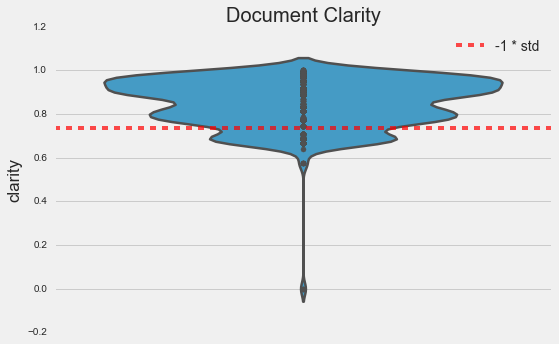

In [16]:
title = 'Document Clarity'
fig, ax = plt.subplots(figsize=(8,5))

sns.violinplot(ax=ax, data=clarity, x='clarity', orient='v', inner='point', linewidth=2.5)
ax.axhline(y=mean_clarity - 1 * std_clarity, linestyle='--', c='r', alpha=.70, label='-1 * std')

plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))

## worker-document score

In [17]:
%%time
#pandas sclicing
idx = pd.IndexSlice

workers = anno_vectors.index.get_level_values('worker_id').unique()
worker_doc_scores = pd.DataFrame()

complete_last = 0
for i,worker in enumerate(workers):
    #status
    complete = round((i/len(workers))*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
    complete_last = complete
    #get list workers minus worker
    workers_minworker = [w for w in workers if w != worker]
    #get docs worker worked on
    worker_docs = anno_vectors.loc[idx[:,worker],:].index.get_level_values('document_id').unique()
    #compute aggregate document vectors including all workers minus worker
    doc_vectors_minworker = anno_vectors.loc[idx[worker_docs,workers_minworker],:].groupby(level=('document_id')).sum()
    for document in worker_docs:
        if document not in ambiguous_docs:
            worker_doc_vector = anno_vectors.loc[idx[document,worker],:]
            doc_vector_minworker = doc_vectors_minworker.loc[document]
            #compute distance
            score = cosine_similarity([worker_doc_vector], [doc_vector_minworker])
            #transform to table row
            row = pd.Series([document, worker, score[0][0]], index=['document_id', 'worker_id', 'score'])
            worker_doc_scores = worker_doc_scores.append(row, ignore_index=True)

#average doc scores per worker
worker_doc_scores = pd.DataFrame(worker_doc_scores.groupby('worker_id')['score'].mean())

2%
4%
6%
8%
10%
12%
14%
16%
18%
20%
22%
24%
26%
28%
30%
32%
34%
36%
38%
40%
42%
44%
46%
48%
50%
52%
54%
56%
58%
60%
62%
64%
66%
68%
70%
72%
74%
76%
78%
80%
82%
84%
86%
88%
90%
92%
94%
96%
98%
Wall time: 27.9 s


#### plot distribution

Enter Multiplier for CutOff: .75
outliers: 72


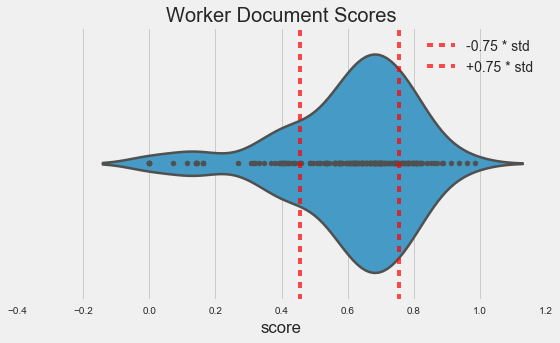

In [18]:
title = 'Worker Document Scores'
fig, ax = plt.subplots(figsize=(8,5))

mean = std = worker_doc_scores['score'].mean()
std = worker_doc_scores['score'].std()

mtplyr = float(input('Enter Multiplier for CutOff: '))

lbound = mean - mtplyr * std
ubound = mean + mtplyr * std

print('outliers: %s' % len(worker_doc_scores[(worker_doc_scores['score'] < lbound) | (worker_doc_scores['score'] > ubound)]))

sns.violinplot(ax=ax, data=worker_doc_scores, x='score', orient='h', inner='point', linewidth=2.5)
ax.axvline(x=lbound, linestyle='--', c='r', alpha=.70, label='-%s * std' % mtplyr)
ax.axvline(x=ubound, linestyle='--', c='r', alpha=.70, label='+%s * std' % mtplyr)

plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))

## worker-worker score

In [19]:
%%time
#sort indexes for sclicing
anno_vectors.sort_index(inplace=True)
idx = pd.IndexSlice

workers = anno_vectors.index.get_level_values('worker_id').unique()
worker_worker_scores = pd.DataFrame()

complete_last = 0
for i,worker1 in enumerate(workers):
    #status
    complete = round((i/len(workers))*100)
    if complete != complete_last:
        if complete % 2 == 0:
            print('%s%%' % complete)
    complete_last = complete
    #get list workers minus worker
    workers_minworker = [w for w in workers if w != worker1]
    #get docs worker worked on
    worker1_docs = anno_vectors.loc[idx[:,worker1],:].index.get_level_values('document_id').unique()
    for worker2 in workers_minworker:
        #get docs worker worked on
        worker2_docs = anno_vectors.loc[idx[:,worker2],:].index.get_level_values('document_id').unique()
        #get overlapping docs
        docs_overlapped = [doc for doc in worker1_docs if doc in worker2_docs]
        for document in docs_overlapped:
            if document not in ambiguous_docs:
                #get annotation vectors for each worker
                worker1_doc = anno_vectors.loc[idx[document,worker1],:]
                worker2_doc = anno_vectors.loc[idx[document,worker2],:]
                worker1_total_annotations = 0
                agreement = 0
                for anno in annotations:
                    #count annotations
                    worker1_total_annotations += worker1_doc[anno] 
                    #get agreement
                    agreement += min(worker1_doc[anno], worker2_doc[anno])
        #get worker worker document score as sum (agreement) / total annotations
        score = agreement / worker1_total_annotations
        #transform to table row
        row = pd.Series([document, worker1, worker2, score], index=['document_id', 'worker1_id', 'worker2_id', 'score'])
        worker_worker_scores = worker_worker_scores.append(row, ignore_index=True)

#average worker doc scores per worker
worker_worker_scores = 1 - pd.DataFrame(worker_worker_scores.groupby('worker1_id')['score'].mean())

2%
4%
6%
8%
10%
12%
14%
16%
18%
20%
22%
24%
26%
28%
30%
32%
34%
36%
38%
40%
42%
44%
46%
48%
50%
52%
54%
56%
58%
60%
62%
64%
66%
68%
70%
72%
74%
76%
78%
80%
82%
84%
86%
88%
90%
92%
94%
96%
98%
Wall time: 2min 24s


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


#### plot distribution

Enter Multiplier for CutOff: .75
outliers: 72


c:\miniconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


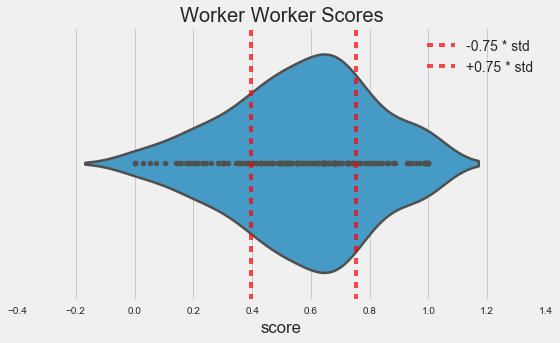

In [20]:
mean = std = worker_worker_scores['score'].mean()
std = worker_worker_scores['score'].std()

title = 'Worker Worker Scores'
fig, ax = plt.subplots(figsize=(8,5))

mtplyr = float(input('Enter Multiplier for CutOff: '))

lbound = mean - mtplyr * std
ubound = mean + mtplyr * std

print('outliers: %s' % len(worker_doc_scores[(worker_worker_scores['score'] < lbound) | (worker_worker_scores['score'] > ubound)]))

sns.violinplot(ax=ax, data=worker_worker_scores, x='score', orient='h', inner='point', linewidth=2.5)
ax.axvline(x=lbound, linestyle='--', c='r', alpha=.70, label='-%s * std' % mtplyr)
ax.axvline(x=ubound, linestyle='--', c='r', alpha=.70, label='+%s * std' % mtplyr)

plt.title(title)
plt.legend(markerscale=2, fontsize=14)
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))

### id outliers

In [21]:
multiplier = .75

In [22]:
wd_out = worker_doc_scores[(worker_doc_scores['score'] < worker_doc_scores['score'].mean() - multiplier * worker_doc_scores['score'].std())
                    | (worker_doc_scores['score'] > worker_doc_scores['score'].mean() + multiplier * worker_doc_scores['score'].std())].index

ww_out = worker_worker_scores[(worker_worker_scores['score'] < worker_worker_scores['score'].mean() - multiplier * worker_worker_scores['score'].std())
                    | (worker_worker_scores['score'] > worker_worker_scores['score'].mean() + multiplier * worker_worker_scores['score'].std())].index

In [23]:
workers_out = [worker for worker in wd_out if worker in ww_out]

In [24]:
print('removing: %s workers, %.2f%%' % (len(workers_out), (len(workers_out) / len(workers) * 100)))

removing: 37 workers, 20.90%


In [25]:
#anno_vectors.loc[idx[:,workers_out],:]

#### drop outliers

In [26]:
cf = cf[cf['worker_id'].isin(workers_out) == False]
cf.shape

(7755, 146)

In [27]:
anno_vectors.drop(workers_out, level='worker_id', inplace=True)
anno_vectors.shape

(7755, 3)

#### count, update annotations per document
- used later for aggregating characteristic annotations (> 50%)

In [28]:
cf_annpertweet = pd.DataFrame(cf.groupby('document_id')['worker_id'].count())
cf_annpertweet.columns = ['doc_annotations']
cf_annpertweet.reset_index(inplace=True)
cf = pd.merge(cf, cf_annpertweet, how='left', on=['document_id'])

In [29]:
cf.groupby('document_id')['doc_annotations'].mean().value_counts()

10    311
9     280
8     129
7      97
6      69
Name: doc_annotations, dtype: int64

### document vectors

In [30]:
doc_vectors = anno_vectors.reset_index().groupby('document_id')[annotations].sum()
doc_vectors.sort_index(inplace=True)
doc_vectors.head()

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
document_id,,,
1000143492,0,1,6
1000143493,2,0,4
1000143494,4,2,3
1000143495,4,0,3
1000143496,4,3,2


### unit vectors
- construct square matrix, of unit verctors
- where diagonal to 1

In [31]:
a = np.zeros([len(annotations), len(annotations)])
np.fill_diagonal(a, val=1)
unit_vectors = pd.DataFrame(a, index=annotations, columns=annotations)
unit_vectors

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
NOT CONTAINS,1.0,0.0,0.0
POSSIBLY CONTAINS,0.0,1.0,0.0
CONTAINS,0.0,0.0,1.0


## document-annotation score
- compute the cosine similarity between each document vector and the unit vector for every annotation
    - Cosine Similarity measures the cosine distance from 0 to 1 between two equal length vectors, and is calculated as $cos(\pmb dv, \pmb uv) = \frac {\pmb dv \cdot \pmb uv}{||\pmb dv|| \cdot ||\pmb uv||}$

In [32]:
x = cosine_similarity(doc_vectors, unit_vectors)
doc_anno_scores = pd.DataFrame(x, columns=annotations)
doc_anno_scores.head()

,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS
0,0.000000,0.164399,0.986394
1,0.447214,0.000000,0.894427
2,0.742781,0.371391,0.557086
3,0.800000,0.000000,0.600000
4,0.742781,0.557086,0.371391


#### plot distribution

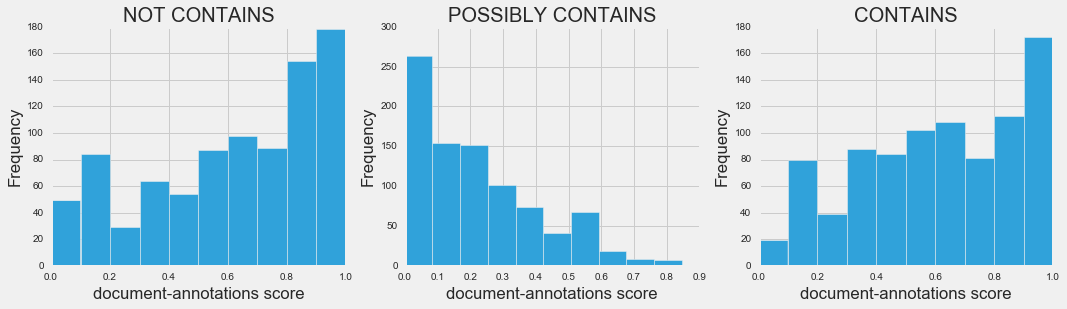

In [33]:
fig, axs = plt.subplots(1,len(annotations), figsize=(16, 4))
for i,ann in enumerate(doc_anno_scores.columns):
    axs[i].hist(doc_anno_scores[ann])
    axs[i].set_title(ann)
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('document-annotations score')
plt.show()

## clarity scores
- maximum document-annotation score
- the score is a measure of clarity, where a higher score represents a more clear interpretation of that annotation for that document
- lower scores depict higher disagreement within the crowd, and suggest difficulty for training a machine

In [34]:
clarity_scores = doc_anno_scores.apply(lambda row: [row[anno] if row[anno] == row.max() else 0 for anno in annotations], axis=1)

#### visualize

c:\miniconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


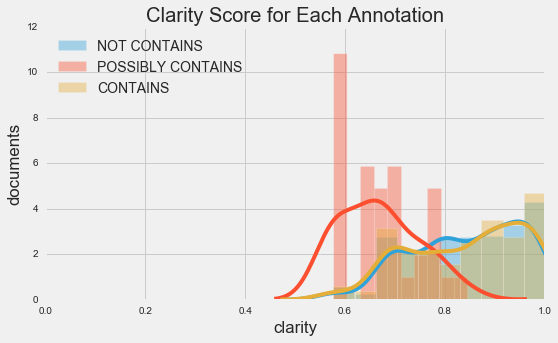

In [35]:
title = 'Clarity Score for Each Annotation'
fig, ax = plt.subplots(figsize=(8,5))

for anno in annotations:
    #sns.distplot(clarity_scores[anno], ax=ax, label=anno, bins=10)
    sns.distplot(clarity_scores[clarity_scores[anno] != 0][anno], ax=ax, label=anno, bins=10)

ax.set_xlim(0,1)
ax.set_xlabel('clarity')
ax.set_ylabel('documents')

plt.title(title)
plt.legend(markerscale=2, fontsize=14, loc='best')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))

#### merge scores to data

In [36]:
#doc_anno_scores.columns = [ann+' clarity' for ann in annotations]
clarity_scores.columns = [ann+' clarity' for ann in annotations]

In [37]:
#anno_results = pd.merge(doc_vectors.reset_index(), doc_anno_scores, left_index=True, right_index=True)
anno_results = pd.merge(doc_vectors.reset_index(), clarity_scores, left_index=True, right_index=True)
anno_results.head()

,document_id,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS,NOT CONTAINS clarity,POSSIBLY CONTAINS clarity,CONTAINS clarity
0,1000143492,0,1,6,0.000000,0.0,0.986394
1,1000143493,2,0,4,0.000000,0.0,0.894427
2,1000143494,4,2,3,0.742781,0.0,0.000000
3,1000143495,4,0,3,0.800000,0.0,0.000000
4,1000143496,4,3,2,0.742781,0.0,0.000000


#### merge results to tweet data

In [38]:
anno_results = pd.merge(cf[['document_id', 'event', 'twitter_id', 'text']].drop_duplicates(), anno_results, how='right', on='document_id')

In [39]:
anno_results.head()

,document_id,event,twitter_id,text,NOT CONTAINS,POSSIBLY CONTAINS,CONTAINS,NOT CONTAINS clarity,POSSIBLY CONTAINS clarity,CONTAINS clarity
0,1000144059,24 Hours of Le Mans,744065054232973312,Race day #RedBull #LeMans24 #Porsche https://t...,3,1,4,0.000000,0.0,0.784465
1,1000144055,24 Hours of Le Mans,744130691026325505,@ProtonRacing @PatrickDempsey with @Christense...,8,0,1,0.992278,0.0,0.000000
2,1000144043,24 Hours of Le Mans,744145930283286528,30 minutes until the start... and here comes t...,4,3,3,0.685994,0.0,0.000000
3,1000144069,24 Hours of Le Mans,744147575616471040,#Now with #BradPitt and .@AdrianaKarembeu at #...,2,2,4,0.000000,0.0,0.816497
4,1000144077,24 Hours of Le Mans,744152740566286336,@24hoursoflemans @FordPerformance @FIAWEC The ...,6,1,2,0.937043,0.0,0.000000


#### plot annotation clarity

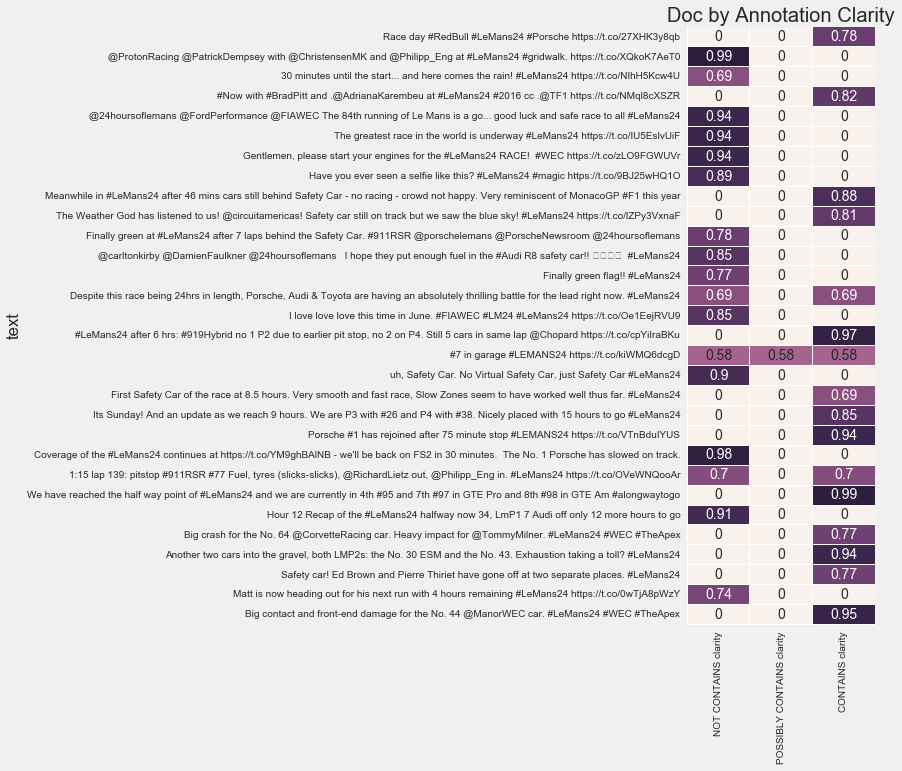

In [40]:
x = anno_results.set_index('text')[clarity_scores.columns].head(30)
plt.figure(figsize=(3, 10))
ax = sns.heatmap(x, annot=True, linewidths=.01, cbar=False)
sns.plt.title('Doc by Annotation Clarity')
plt.show()

## Compare to Manually Annotated (Strict)

#### News
- import manually annotated
- merge crowd annotations with expert
- export this data (for manual analysis in excel)

In [41]:
#cf_man = pd.read_csv('data/final/cf_report_manualtest100.csv', sep=',', encoding='utf-8', header=0)
#cf_man.sort_values(by=['event', 'event_id', 'text'], inplace=True)
#cf_man.shape

In [42]:
#print('expert:')
#print('%s unique annotations' % cf_man['id'].unique().shape[0])
#print('%s unique tweets annotated' % cf_man.groupby(['event', 'event_id']).size().shape[0])

In [43]:
#cf_man['news'].replace(annotation_codes, inplace=True)

#for ann in annotations:
#    cf_man[ann] = cf_man['news'].apply(lambda a: [0,1][a == ann])

In [44]:
#anno_results_crowd = anno_results.set_index(['event', 'event_id', 'text'])
#anno_results_manual = cf_man.set_index(['event', 'event_id', 'text'])[annotations]

#anno_results_out = pd.merge(anno_results_crowd, anno_results_manual, left_index=True, right_index=True)

#anno_results_out.to_csv('annotation_results.txt', sep='\t')

## 2.5 Apply Clarity Scores to Characteristics

In [45]:
characteristics = ['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']

for char in characteristics:
    cf[char] = cf['characteristics'].apply(lambda q: 1 if char in [i for i in str(q).split('\n')] else 0)

#### document vectors

In [46]:
#doc_vectors = cf.groupby(['event', 'event_id', 'text', 'doc_annotations'])[characteristics].sum()
doc_vectors = cf.groupby('document_id')[characteristics].sum()
doc_vectors.sort_index(inplace=True)
doc_vectors.head()

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
document_id,,,,,,,,
1000143492,0,3,1,1,0,0,0,0
1000143493,0,2,2,1,0,1,0,0
1000143494,0,0,6,2,1,0,0,0
1000143495,1,4,4,0,0,0,0,0
1000143496,1,1,5,0,0,1,0,0


#### unit vectors

In [47]:
a = np.zeros([len(characteristics), len(characteristics)])
np.fill_diagonal(a, val=1)
unit_vectors = pd.DataFrame(a, index=characteristics, columns=characteristics)
unit_vectors

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
question,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
advertisement,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
opinion,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
quote,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
sarcasm,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
explicit,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
lang,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### document-annotation scores

In [48]:
x = cosine_similarity(doc_vectors, unit_vectors)
doc_anno_scores = pd.DataFrame(x, columns=characteristics)
doc_anno_scores.head()

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
0,0.000000,0.904534,0.301511,0.301511,0.000000,0.000000,0.0,0.0
1,0.000000,0.632456,0.632456,0.316228,0.000000,0.316228,0.0,0.0
2,0.000000,0.000000,0.937043,0.312348,0.156174,0.000000,0.0,0.0
3,0.174078,0.696311,0.696311,0.000000,0.000000,0.000000,0.0,0.0
4,0.188982,0.188982,0.944911,0.000000,0.000000,0.188982,0.0,0.0


#### clarity scores

In [49]:
clarity_scores = doc_anno_scores.apply(lambda row: [row[char] if row[char] == row.max() else 0 for char in characteristics], axis=1)
clarity_scores.head()

,question,advertisement,opinion,quote,sarcasm,explicit,lang,error
0,0.0,0.904534,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.632456,0.632456,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.937043,0.0,0.0,0.0,0.0,0.0
3,0.0,0.696311,0.696311,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.944911,0.0,0.0,0.0,0.0,0.0


#### visualize

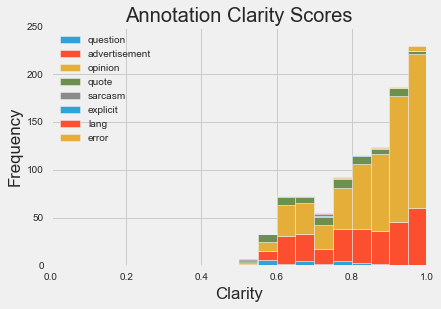

In [50]:
ax = clarity_scores[clarity_scores != 0].plot(kind='hist', stacked=True, alpha=1)
ax.set_xlim(0,1)
ax.set_title('Annotation Clarity Scores')
ax.set_xlabel('Clarity')
plt.show()

#### merge scores to data

In [51]:
doc_anno_scores.columns = [ann+' clarity' for ann in characteristics]
char_results = pd.merge(doc_vectors.reset_index(), doc_anno_scores, left_index=True, right_index=True)
char_results.head()

,document_id,question,advertisement,opinion,quote,sarcasm,explicit,lang,error,question clarity,advertisement clarity,opinion clarity,quote clarity,sarcasm clarity,explicit clarity,lang clarity,error clarity
0,1000143492,0,3,1,1,0,0,0,0,0.000000,0.904534,0.301511,0.301511,0.000000,0.000000,0.0,0.0
1,1000143493,0,2,2,1,0,1,0,0,0.000000,0.632456,0.632456,0.316228,0.000000,0.316228,0.0,0.0
2,1000143494,0,0,6,2,1,0,0,0,0.000000,0.000000,0.937043,0.312348,0.156174,0.000000,0.0,0.0
3,1000143495,1,4,4,0,0,0,0,0,0.174078,0.696311,0.696311,0.000000,0.000000,0.000000,0.0,0.0
4,1000143496,1,1,5,0,0,1,0,0,0.188982,0.188982,0.944911,0.000000,0.000000,0.188982,0.0,0.0


#### merge scores to tweet data

In [52]:
char_results = pd.merge(cf[['document_id', 'event', 'twitter_id', 'doc_annotations', 'text']].drop_duplicates(), char_results, how='right', on='document_id')

## 3. Aggregate Annotations
### News
- using clarity score
- take that annotation which is greater than .85
    - if annotation > .85 then 1 else 0
- in cases where no annotations were > .85
    - these ambigous cases are excluded from the training data

In [53]:
anno_results['news agg'] = np.nan
anno_results['news agg'] = anno_results.apply(lambda row: [0,1][row['CONTAINS clarity'] >= .8], axis=1)
#anno_results['news agg'][anno_results['NOT CONTAINS clarity'] >= .85] = 0
#anno_results['news agg'][anno_results['CONTAINS clarity'] >= .85] = 1

anno_results_agg = anno_results[anno_results['news agg'].isnull() == False][['event', 'twitter_id', 'news agg']]
anno_results_agg.columns = ['event', 'twitter_id', 'news']

### Characteristics
- using majority vote

In [54]:
char_results['question agg'] = char_results.apply(lambda row: [0,1][row['question'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['advertisement agg'] = char_results.apply(lambda row: [0,1][row['advertisement'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['opinion agg'] = char_results.apply(lambda row: [0,1][row['opinion'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['quote agg'] = char_results.apply(lambda row: [0,1][row['quote'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['sarcasm agg'] = char_results.apply(lambda row: [0,1][row['sarcasm'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['explicit agg'] = char_results.apply(lambda row: [0,1][row['explicit'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['lang agg'] = char_results.apply(lambda row: [0,1][row['lang'] > (row['doc_annotations'] / 2)] , axis=1)
char_results['error agg'] = char_results.apply(lambda row: [0,1][row['error'] > (row['doc_annotations'] / 2)] , axis=1)

In [55]:
#char_results['question agg'] = 0
#char_results['question agg'][char_results['question clarity'] > .85] = 1
#char_results['advertisement agg'] = 0
#char_results['advertisement agg'][char_results['advertisement clarity'] > .85] = 1
#char_results['opinion agg'] = 0
#char_results['opinion agg'][char_results['opinion clarity'] > .85] = 1
#char_results['quote agg'] = 0
#char_results['quote agg'][char_results['quote clarity'] > .85] = 1
#char_results['sarcasm agg'] = 0
#char_results['sarcasm agg'][char_results['sarcasm clarity'] > .85] = 1
#char_results['explicit agg'] = 0
#char_results['explicit agg'][char_results['explicit clarity'] > .85] = 1
#char_results['lang agg'] = 0
#char_results['lang agg'][char_results['lang clarity'] > .85] = 1
#char_results['error agg'] = 0
#char_results['error agg'][char_results['error clarity'] > .85] = 1

In [56]:
char_results_agg = char_results[['event', 'twitter_id', 'question agg', 'advertisement agg', 'opinion agg', 'quote agg', 'sarcasm agg', 'explicit agg', 'lang agg', 'error agg']]
cols = ['event', 'twitter_id']
cols.extend(characteristics)
char_results_agg.columns = cols

#### merge aggregate annotations

In [57]:
cf_agg = pd.merge(anno_results_agg, char_results_agg, how='inner', on=['event', 'twitter_id'])
cf_agg.shape

(886, 11)

#### export aggregate annotaions

In [58]:
cf_agg.to_csv('data/final/tweet_annotations_agg_FINAL.txt', sep='\t', encoding='utf-8', header=True, index=False)

## 4. Summarize
- high level summary

#### add none (characteristics) column

In [59]:
cf_agg['none'] = cf_agg.apply(lambda x: [0,1][x[characteristics].sum() == 0], axis=1)

In [70]:
#d1 = cf_agg.reset_index()['event'].value_counts(normalize=True)
#d2 = cf_agg.reset_index().groupby('event')['news'].sum() / cf_agg.shape[0]
#d = pd.merge(pd.DataFrame(d1), pd.DataFrame(d2), left_index=True, right_index=True)
#d.columns = ['% of annotated', '% of news']
#d.plot(kind='barh', xlim=[0,1], title='Annotations per Event')
#plt.xlim(0,.2)
#plt.show()

#d = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].apply(pd.Series.value_counts).iloc[1]
#d.plot(kind='bar', title='Annotations per Characteristic', label='Tweets')
#plt.legend(loc='best')
#plt.show()

#d = cf_agg['news'].value_counts()
#d.plot(kind='bar', title='Annotations per News', label='Tweets')
#plt.legend(loc='best')
#plt.show()

- in depth summary

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


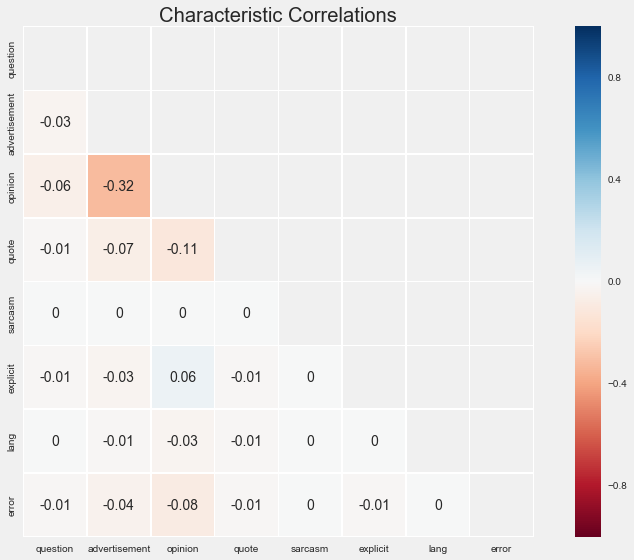

In [61]:
x = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none', 'news']]

fig, ax = plt.subplots(figsize=(12,8))

#ax = sns.heatmap((x.T.dot(x)), annot=True, square=True, linewidths=.5)
#title = 'Co Occurrences'

#ax = sns.heatmap(round(x.T.dot(x) / cf_agg.shape[0], 2), annot=True, square=True, linewidths=.5)
#title = '% Co Occurrences'

xcorr = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error']].corr()
mask = np.full(xcorr.shape, False, dtype=bool)
mask[np.triu_indices(len(xcorr))] = True
ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, mask=mask, cmap='RdBu', linewidths=.5)
title = 'Characteristic Correlations'

#xcorr = cf_agg[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)
#xcorr = pd.DataFrame(xcorr, columns=['news'])
#ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
#title = 'News Correlations'

plt.title(title)
plt.legend(markerscale=2, fontsize=14, loc='upper center')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))

#### apply event types

In [62]:
event_domain = {
    'UEFA Champions League Final' : 'Sporting Event',
    'French Open Finals' : 'Sporting Event',
    'Monaco Grand Prix' : 'Sporting Event',
    'Stanley Cup Playoffs Final Game 7' : 'Sporting Event',
    '24 Hours of Le Mans' : 'Sporting Event',
    'NBA Playoffs Finals Game 7': 'Sporting Event',
    'The Next Web Conference Europe' : 'Technology Conference',
    'Recode Code Conference' : 'Technology Conference',
    'Google I/O' : 'Technology Conference',
    'Apple Worldwide Developer Conference' : 'Technology Conference',
    'Lenovo Tech World' : 'Technology Conference',
    'Xbox E3' : 'Technology Conference',
    }

cf_agg['event_domain'] = cf_agg['event']
cf_agg['event_domain'].replace(event_domain, inplace=True)

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


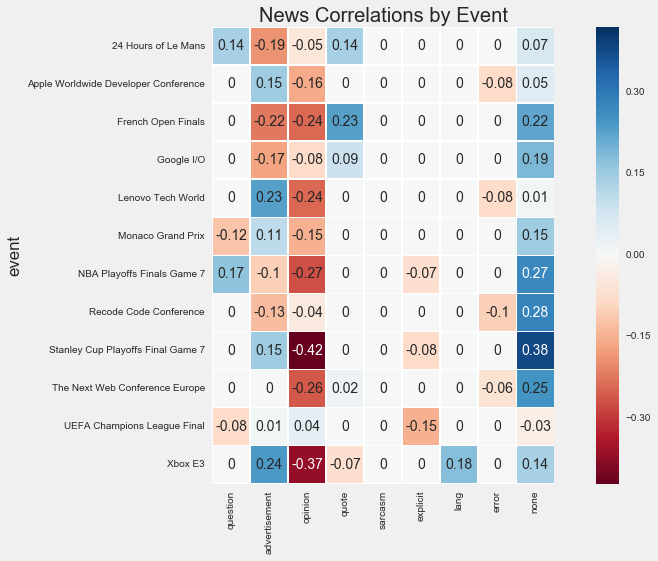

In [63]:
xcorr = cf_agg.groupby('event')[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)

fig, ax = plt.subplots(figsize=(12,8))

ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
title = 'News Correlations by Event'

plt.title(title)
plt.legend(markerscale=2, fontsize=14, loc='upper center')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))

c:\miniconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


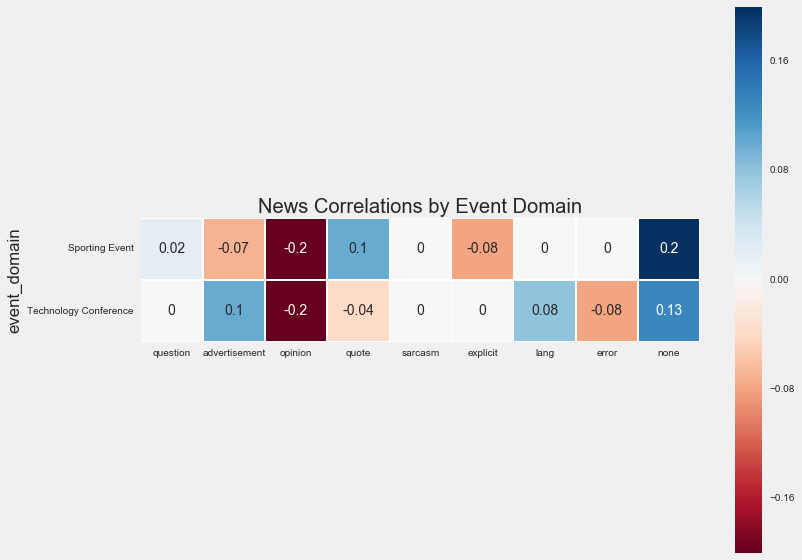

In [64]:
xcorr = cf_agg[cf_agg['event_domain'].isin(['Sporting Event', 'Technology Conference'])].groupby('event_domain')[['question', 'advertisement', 'opinion', 'quote', 'sarcasm', 'explicit', 'lang', 'error', 'none']].corrwith(cf_agg['news'], axis=0)
#xcorr = xcorr.reset_index().groupby('event_type').mean()

fig, ax = plt.subplots(figsize=(12,8))

ax = sns.heatmap(round((xcorr.replace(np.nan, 0)), 2), annot=True, square=True, cmap='RdBu', linewidths=.5)
title = 'News Correlations by Event Domain'

plt.title(title)
plt.legend(markerscale=2, fontsize=14, loc='upper center')
fig = plt.gcf()
plt.tight_layout()
plt.show()
fig.savefig('images/crowdtruth_%s.png' % title.replace(' ', '_'))